In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from pathlib import Path
import os
import torch
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.nn import ReLU
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn import preprocessing

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 資料處理

In [4]:
rawdata = pd.read_csv('/content/drive/My Drive/DataMining/Dataset.csv')
rawdata

,egg_TaijinPrice,Duckegg_TNN_TaijinPrice,入中雞雛數,產蛋隻數,均 日 產蛋箱數,淘汰隻數,目 前 換羽隻數,Date,WhiteChickQuantity,RedChickQuantity,...,嘉義_Precipitation,臺東_AirTemperatureMean,臺東_AirTemperatureMax,臺東_Precipitation,鞍部_AirTemperatureMean,鞍部_AirTemperatureMax,鞍部_Precipitation,馬祖_AirTemperatureMean,馬祖_AirTemperatureMax,馬祖_Precipitation
0,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-01,245600,84800,...,0.0,19.1,25.4,0.0,10.6,20.7,4.0,10.7,21.8,0.0
1,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-02,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.5,10.7,21.8,0.0
2,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-03,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.7,10.7,21.8,0.0
3,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-04,245600,84800,...,5.0,19.1,25.4,4.2,10.6,20.7,0.0,10.7,21.8,0.1
4,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-05,245600,84800,...,4.5,19.1,25.4,10.5,10.6,20.7,9.3,10.7,21.8,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-27,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,1.0,11.9,19.4,0.0
1822,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-28,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,21.0,11.9,19.4,0.0
1823,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-29,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,19.5,11.9,19.4,0.0
1824,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-30,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,39.5,11.9,19.4,0.0


#### 整理成 index 為日期的格式

In [75]:
col_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation','egg_TaijinPrice']

orid = pd.DataFrame(columns=col_list, index=rawdata['Date'])

for i in col_list:
    counter =0
    for j in rawdata['Date']:
        orid[i][j] = rawdata[i][counter]
        counter+=1
    if (orid[i].isnull().any()):
        orid[i] = orid[i].fillna(orid[i].mean())

oridata = pd.DataFrame()
for col in col_list:

    data_pre = np.array(orid[col])
    if(col != 'egg_TaijinPrice'):
      data_pre = preprocessing.normalize([data_pre])
      data_pre = data_pre.reshape(1826,1)
    data_pre = pd.DataFrame(data_pre)
    oridata = pd.concat((oridata, data_pre),axis=1)

<ipython-input-75-bfc98baa343a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orid[i][j] = rawdata[i][counter]


In [76]:
oridata

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,24.5
1,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,24.5
2,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,26.5
3,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019627,0.016452,0.019250,0.005391,26.5
4,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019612,0.016452,0.019250,0.000674,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.027656,0.031693,0.028500,0.029559,0.031201,0.016928,0.019887,0.000000,40.5
1822,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.028166,0.031693,0.028696,0.029559,0.031201,0.016928,0.019887,0.000000,40.5
1823,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028166,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000135,40.5
1824,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028548,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000000,40.5


### 切 train and test

In [77]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix+1 > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X,dtype=float), array(y,dtype=float)


# choose a number of time steps
n_steps = 30
# convert into input/output
dataset_ar = np.array(oridata)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps)

In [78]:
print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1796


1431

In [79]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1431, 30, 18) (1431,)
Test data shape:  (365, 30, 18) (365,)


In [80]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

### Define CNN

In [19]:
n_features = Train_x.shape[2]
n_step = 30

In [81]:
# define model
class CNN(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super().__init__()
        # self.layers = torch.nn.Sequential(
        #     # initialize first set of CONV => RELU => POOL layers
        #     # input shape(1*17*17)
        #     torch.nn.Conv1d(in_channels=n_features, out_channels=36, kernel_size=5, stride=1), # output shape(batch*36*26)
        #     torch.nn.ReLU(),
        #     torch.nn.Conv1d(in_channels=36, out_channels=18, kernel_size=5, stride=1), # output shape(batch*18*22)
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool1d(kernel_size=22), # output shape(batch*18*1)
        # )
        self.Conv1 = torch.nn.Conv1d(in_channels=n_features, out_channels=36, kernel_size=5, stride=1)
        self.ReLu1 = torch.nn.ReLU()
        self.Conv2 = torch.nn.Conv1d(in_channels=36, out_channels=18, kernel_size=5, stride=1)
        self.ReLu2 = torch.nn.ReLU()
        self.MaxPool = torch.nn.MaxPool1d(kernel_size=22)
        self.linear = torch.nn.Linear(18, 1)
        # self.layer1 = torch.nn.Sequential(
        #   torch.nn.Conv2d(1,32,kernel_size=3,padding=1),
        #   torch.nn.ReLU(),
        #   torch.nn.MaxPool2d(2,2))

        # self.layer2 = torch.nn.Sequential(
        #   torch.nn.Conv2d(32,64,kernel_size=3,padding=1),
        #   torch.nn.ReLU(),
        #   torch.nn.MaxPool2d(2,2))


        # self.flattened_tensor = torch.nn.Flatten()

        # self.linear_layer = torch.nn.Sequential(
        #   torch.nn.Linear(64,4),
        #   torch.nn.ReLU(),
        #   torch.nn.Linear(4,1))


    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.Conv1(x)
        # print("\n","Conv1 output shape", x.shape)
        x = self.ReLu1(x)
        # print("\n","ReLU1 output shape", x.shape)
        x = self.Conv2(x)
        # print("\n","Conv2 output shape", x.shape)
        x = self.ReLu2(x)
        # print("\n","ReLU2 output shape", x.shape)
        x = self.MaxPool(x)
        # print("\n","MaxPool output shape", x.shape)
        x = x.view(-1,x.size(1))
        x = self.linear(x)
        # print("\n","After linear shape", x.shape)
        return x

### MSPE

In [23]:
def MSPE(pred, labels):

    # l1_or = torch.nn.L1Loss(reduction="none")

    pred = pred.to(device)
    labels = labels.to(device)
    diff = pred - labels
    result = torch.mean(torch.pow(diff/labels , 2))

    return result

### Define Train

In [83]:
def train(trainloader, model, optimizer, epochs) :

    loss_MSE = torch.nn.MSELoss(reduction="mean")
    # loss_SSE = torch.nn.MSELoss(reduction="sum")
    # criterion = torch.nn.CrossEntropyLoss()

    train_rmse_list = []
    output_list = []
    train_rmse = 0
    train_mse = 0
    val_rmse = 0
    best_tra_rmse = 20
    step_cnt = 0
    best_step_cnt = 0


    for epoch in tqdm(range(epochs)):

        # Set current loss value
        train_loss = 0

        # Iterate over data in train loader
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(i, inputs.shape)
            labels = labels.reshape((-1, 1))
            step_cnt += 1
            model.train()

            optimizer.zero_grad()
            outputs = model(inputs)
            # output_list.append(outputs)
            train_loss = loss_MSE(outputs, labels)
            train_loss.backward()
            optimizer.step()

             #每 100 個 batch 算一次
            if (step_cnt % 100 == 0):
                train_mse = loss_MSE(outputs, labels)
                train_rmse = torch.sqrt(train_mse)
                train_rmse_list.append(train_rmse)

                if (train_rmse < best_tra_rmse):
                    # step_after_best = 0
                    best_step_cnt = step_cnt
                    best_tra_rmse = train_rmse
                    torch.save(model, 'best_model.pt') # Save model parameters


    return best_step_cnt, best_tra_rmse, train_rmse_list, output_list

### define test

In [34]:
def test(testloader, model):
    loss_MSE = torch.nn.MSELoss(reduction="mean")
    test_count = 0
    mse_test = 0
    mspe_test = 0
    outputlist = []
    for data in tqdm(testloader):
        test_count+=1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        op_test = model(x_test)
        outputlist.append(op_test)
        mse_test += loss_MSE(op_test,y_test)
        mspe_test += MSPE(op_test,y_test)
    MSE_test = mse_test/test_count
    MSPE_test = mspe_test/test_count
    RMSE_test = torch.sqrt(MSE_test)
    return MSE_test, RMSE_test, MSPE_test,outputlist

### 預測 2022 蛋價, step = 30, time_unit = day

In [84]:
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 100

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 100/100 [00:11<00:00,  9.07it/s]

best_step_cnt:  3800
best_tra_rmse:  tensor(1.4510, device='cuda:0', grad_fn=<SqrtBackward0>)


In [85]:
# Q2 Test
# model = torch.load('best_model.pt')
# model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 522.30it/s]


 Test MSE: tensor(4.6769, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(2.1626, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


In [102]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

[32.81120300292969,
 32.812313079833984,
 32.81423568725586,
 32.81656265258789,
 32.81975173950195,
 32.82308578491211,
 32.82550811767578,
 32.827491760253906,
 32.829368591308594,
 32.83085250854492,
 32.83205795288086,
 32.833011627197266,
 32.83425521850586,
 32.835235595703125,
 32.83573532104492,
 32.83592224121094,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83586883544922,
 32.83541488647461,
 32.83481979370117,
 32.834346771240234,
 32.83419418334961,
 32.83419418334961,
 32.83419418334961,
 32.836036682128906,
 33.057552337646484,
 33.29655838012695,
 33.565879821777344,
 33.911563873291016,
 34.247333

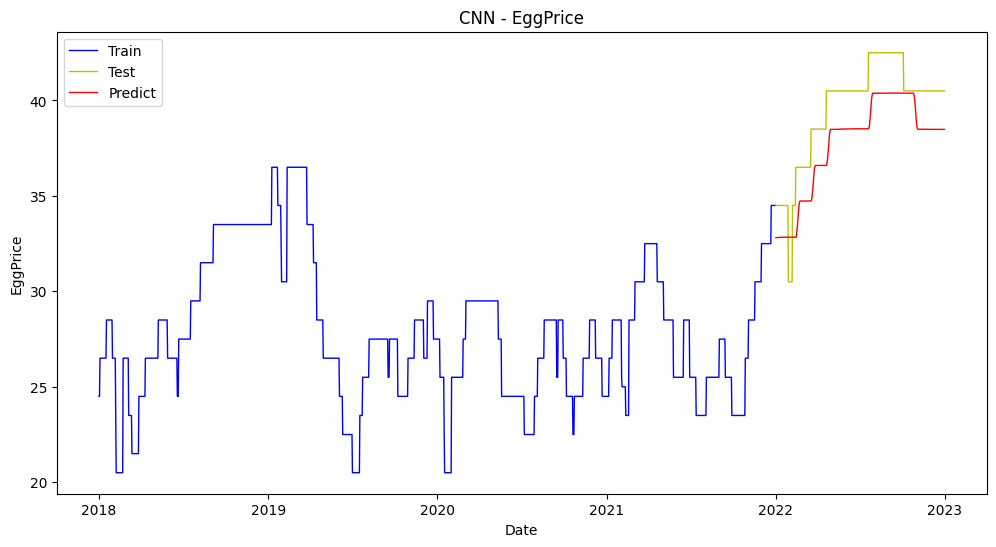

In [103]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(12, 6))

plt.title(f"CNN - EggPrice")

newdate_train = pd.to_datetime(rawdata['Date'][:1461])
newdate_test = pd.to_datetime(rawdata['Date'][1461:])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
# fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

# plt.xlim([2018, 2023])

x_train = newdate_train
y_train = orid['egg_TaijinPrice'][:1461]
plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

x_test = newdate_test
y_test = orid['egg_TaijinPrice'][1461:]
plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

y_pred = output
plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

plt.xlabel("Date")
plt.ylabel("EggPrice")
plt.legend()

In [104]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

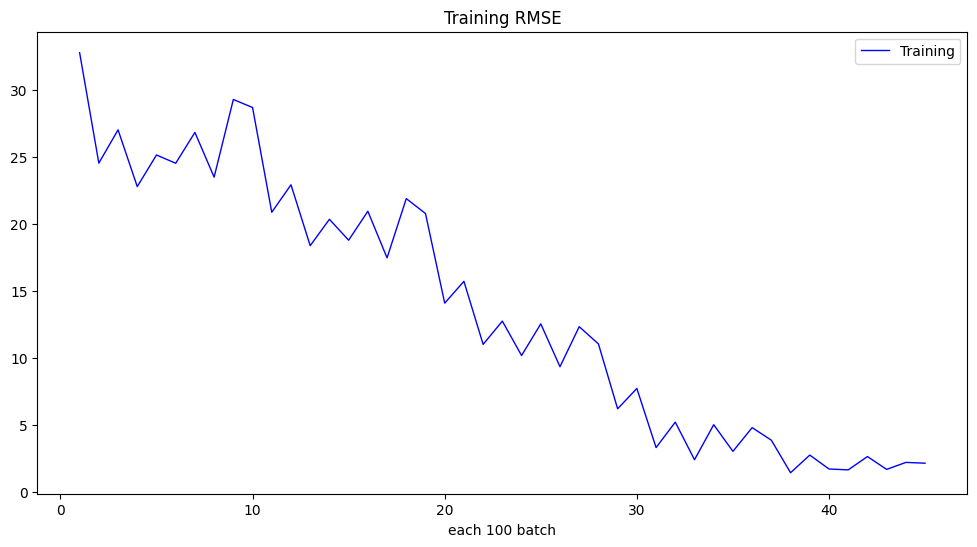

In [105]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

plt.title(f"Training RMSE")

x = range(1, len(train_RMSE)+1)

x_train = list(x)
y_train = train_RMSE
plt.plot(x_train, y_train, 'b', linewidth=1, label="Training")


plt.xlabel("each 100 batch")
plt.ylabel("")
plt.legend()